In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.datasets

# 特徴量の影響度
fANOVAで特徴量の影響度を可視化する   

## 検証用のデータセットを用意する.    
sklearnのirisデータセットを使用する

In [2]:
X = pd.DataFrame(sklearn.datasets.load_iris()['data'],columns=sklearn.datasets.load_iris()['feature_names'])
y = pd.DataFrame(sklearn.datasets.load_iris()['target'],columns=['species'])
dataset = pd.concat([X,y],axis=1)

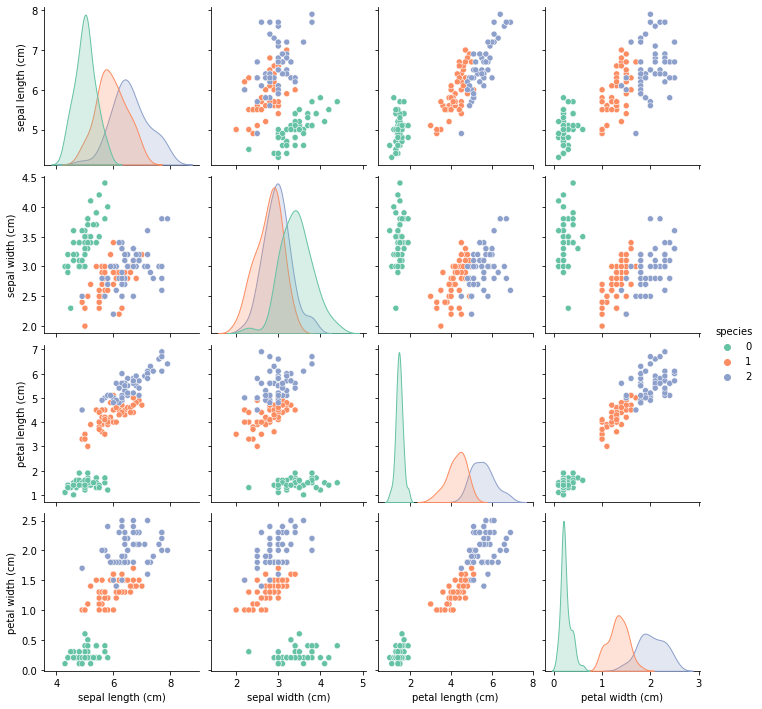

In [3]:
sns.pairplot(dataset, hue='species', palette='Set2')

## fANOVAの実行

In [4]:
from functionalANOVA.fanova import FunctionalANOVA

In [5]:
anova = FunctionalANOVA(X=X,y=y, degree=1)

In [6]:
anova.importances

,importance_value,importance_error,marginal_feature_name
0,0.004635,0.006513,sepal length (cm)
1,0.006476,0.011742,sepal width (cm)
2,0.458896,0.406419,petal length (cm)
3,0.431331,0.393676,petal width (cm)


<AxesSubplot:xlabel='marginal_feature_name', ylabel='importance_value'>

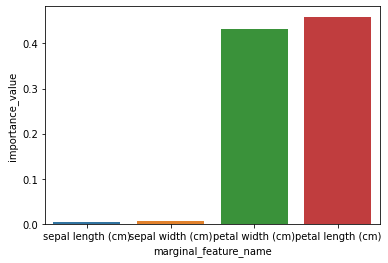

In [7]:
sns.barplot(x='marginal_feature_name',y='importance_value',data=anova.importances.sort_values('importance_value'))

### fANOVAで個別の寄与率と積の寄与率をみたいとき

In [12]:
# データを準備する.
X = np.random.normal(0,1.0,(100,3))
y = 0*X[:,0] + 2.0*X[:,1] + 2.0*X[:,2] + 1.0*X[:,1]*X[:,2]

このモデルは、特徴量1は結果に寄与しない。特徴量2,3はそれぞれ同じくらい寄与し, 特徴量2,3の積の寄与は1,2に比べて半分くらいの設定としている.

In [13]:
X = pd.DataFrame(X,columns=['f1','f2','f3'])
y = pd.DataFrame(y,columns=['val'])

In [14]:
anova = FunctionalANOVA(X=X,y=y)

In [15]:
Imp = anova.importances

In [27]:
Imp

,importance_value,importance_error,marginal_feature_name
0,0.003313,0.005585,f1
1,0.354571,0.112809,f2
2,0.480843,0.142076,f3


寄与全体をUとすると, 
$$U = f1 \cap \bar{f2} \cap \bar{f3} + f2 \cap \bar{f3} \cap \bar{f1} + f3 \cap \bar{f1} \cap \bar{f2} + f1 \cap f2 \cap \bar{f3} + f2 \cap f3 \cap \bar{f1} + f3 \cap f1 \cap \bar{f2} + f1 \cap f2 \cap f3 $$
と分解できる.
fANOVAの出力であるmarginal_feature_name がf1, f2 ,f3は, それぞれ $f1 \cap \bar{f2} \cap \bar{f3}, f2 \cap \bar{f3} \cap \bar{f1}, f3 \cap \bar{f1} \cap \bar{f2}$ を表している.

この問題設定では、$f1 \cap \bar{f2} \cap \bar{f3} = 0$ である. 
また、f1が絡む積の寄与率 $f1 \cap f2 \cap \bar{f3}, f1 \cap f3 \cap \bar{f2}, f1 \cap f2 \cap f3$は、0となる.

積の寄与率( $f2 \cap f3 \cap \bar{f1}$ )は、次のメゾットを使用することで求められる.

In [16]:
Imp_f12 = anova.get_importances((1,2))

In [17]:
subsets = [float(format(Imp.query("marginal_feature_name == 'f1'").importance_value.item(),'.2f')),
           float(format(Imp.query("marginal_feature_name == 'f2'").importance_value.item(),'.2f')),
           0,
           float(format(Imp.query("marginal_feature_name == 'f3'").importance_value.item(),'.2f')),
           0,
           float(format(Imp_f12[0],'.3f')),
           0]

ven図で表すと,

/Users/johnkiyo/.venv/machinelearning/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


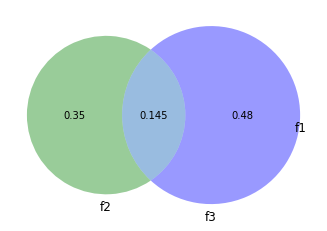

In [18]:
from matplotlib_venn import venn3
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = fig.add_subplot(111)
venn3(subsets = subsets, 
      set_labels = ('f1', 'f2', 'f3'), 
      ax=ax)
plt.show()

ANOVA分析時にdegreeを指定することで、和の寄与率を求めることもできる.

In [19]:
anova_2deg = FunctionalANOVA(X=X,y=y, degree=2)

In [20]:
anova_2deg.importances

,importance_value,importance_error,marginal_feature_name
0,0.003313,0.005585,f1
1,0.354571,0.112809,f2
2,0.480843,0.142076,f3
3,0.362240,0.115809,f1 f2
4,0.489229,0.138416,f1 f3
5,0.980362,0.020685,f2 f3


marginal_feature_name f1f2, f1f3, f2f3は, それぞれ, $f1 \cup f2 \cap \bar{f3}, f1 \cup f3 \cap \bar{f2}, f2 \cup f3 \cap \bar{f1}$である.

従って、次の計算が成り立つ.
$$
f2 \cup f3 \cap \bar{f1} - f2 \cap \bar{f1} \cap \bar{f3} - f3 \cap \bar{f1} \cap \bar{f2} = f2 \cap f3 \cap \bar{f1} 
$$

In [26]:
anova_2deg.importances.importance_value[5] - anova_2deg.importances.importance_value[1] - anova_2deg.importances.importance_value[2] 

0.14494784677419031